# Detector - Object Detection

## Dataset

First - let's download the dataset from - https://www.robots.ox.ac.uk/~vgg/data/pets/

This dataset contains different breeds of cats and dogs with xml annotations for object detection.

In [ ]:
%cd /content/
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

/content
--2021-03-09 09:23:56--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  21.3MB/s    in 36s     

2021-03-09 09:24:33 (20.8 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]



In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2021-03-09 09:24:33--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  10.9MB/s    in 1.7s    

2021-03-09 09:24:35 (10.9 MB/s) - ‘annotations.tar.gz’ saved [19173078/19173078]



In [ ]:
import tarfile

for archive in ['/content/annotations.tar.gz', '/content/images.tar.gz']:
  if archive.endswith("tar.gz"):
      tar = tarfile.open(archive, "r:gz")
      tar.extractall()
      tar.close()

There is a difference in amount of jpg and xml files, meaning some of the images are missing annotations. 

In [ ]:
len(os.listdir('/content/annotations/xmls'))

3686

In [ ]:
len(os.listdir('/content/images'))

7393

Let's isolate only cats data from the dataset. We need a list of cat breeds to isolate cat data from the cats'n'dogs dataset. We'll keep three breeds out of our initial training data set so that we can add them later, and our models would never see those breeds before. This will help us evaluate how well our detector can evaluate on what a cat in general is, rather than learn to recognize breeds we showed it during training.

In [ ]:
# Two-word names aare without spaces, otherwise the code will omit them
cat_breeds = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'BritishShorthair', 'EgyptianMau', 'MaineCoon', 'Siamese', 'Sphynx']

In [ ]:
import shutil
import re
import os

cat_dataset_dir = '/content/cat_data/'
added_cat_dataset_dir = '/content/added_cat_data/'

try: 
  os.mkdir(cat_dataset_dir)
  os.mkdir(added_cat_dataset_dir)
except OSError as error: 
  pass 

# Copy annotations first
annotations_folder = '/content/annotations/xmls'
for file in os.listdir(annotations_folder):
  species = re.sub('[^a-zA-Z]+', '', file[:-4])
  if species in cat_breeds:
    shutil.copyfile(os.path.join(annotations_folder, file), os.path.join(cat_dataset_dir, file))

# Copy images based on annotations we copied in the previous step. This way we 
# avoid images for which xml. annotions are missing. 
images_folder = '/content/images'
for file in os.listdir(cat_dataset_dir):
  file_name = file[:-3] + 'jpg'
  shutil.copyfile(os.path.join(images_folder, file_name), os.path.join(cat_dataset_dir, file_name))

## Model architecture - TensorFlow Object Detection API

### Installing required libraries and scripts

Let's make a folder for our Detector model and download a few necessary files there.

In [ ]:
import os

detector_model_dir = '/content/Detector_Model/'
scripts_dir = '/content/Detector_Model/scripts'

try: 
  os.mkdir(detector_model_dir)
  os.mkdir(scripts_dir)
except OSError as error: 
  pass 

Now we can move onto building our detector. We're gonna use TensorFlow's Object Detection API - a robust library for object detection applications.

In [ ]:
from IPython.display import clear_output

%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib tf_slim lvis

!pip install -q pycocotools

!pip install -q tensorflow_addons

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

%set_env PYTHONPATH=/content/models/research:/content/models/research/slim
import os
os.environ['PYTHONPATH'] += ":/content/models"
import sys
sys.path.append("/content/models")

clear_output()
!python object_detection/builders/model_builder_test.py

/content


In [ ]:
!python /content/Detector_Model/models/research/object_detection/builders/model_builder_tf2_test.py

### Dataset

This script splits out dataset into training and testing parts.

In [ ]:
!wget -O '{scripts_dir}/partition_dataset.py' https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/d0e545609c5f7f49f39abc7b6a38cec3/partition_dataset.py 

--2021-02-22 22:12:56--  https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/d0e545609c5f7f49f39abc7b6a38cec3/partition_dataset.py
Resolving tensorflow-object-detection-api-tutorial.readthedocs.io (tensorflow-object-detection-api-tutorial.readthedocs.io)... 104.17.33.82, 104.17.32.82, 2606:4700::6811:2052, ...
Connecting to tensorflow-object-detection-api-tutorial.readthedocs.io (tensorflow-object-detection-api-tutorial.readthedocs.io)|104.17.33.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3577 (3.5K) [text/x-python]
Saving to: ‘/content/Detector_Model/scripts/partition_dataset.py’

/content/Detector_M 100%[===================>]   3.49K  --.-KB/s    in 0s      

2021-02-22 22:12:56 (37.2 MB/s) - ‘/content/Detector_Model/scripts/partition_dataset.py’ saved [3577/3577]



In [ ]:
!python '{scripts_dir}/partition_dataset.py' -x -i '{cat_dataset_dir}' -r 0.1

Next we need to tell our models what labels we have in our xml files - in this case there's just only one - cat.

In [ ]:
label_map_string = "item {\n\tid: 1\n\tname: 'cat'\n}"
with open(os.path.join(detector_model_dir, 'label_map.pbtxt'), "w") as text_file:
    text_file.write(label_map_string)

And final dataset preparation step - let's convert out images into tf.record files.

In [ ]:
!wget -O '{scripts_dir}/generate_tfrecord.py' https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py

--2021-02-22 22:12:57--  https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py
Resolving tensorflow-object-detection-api-tutorial.readthedocs.io (tensorflow-object-detection-api-tutorial.readthedocs.io)... 104.17.33.82, 104.17.32.82, 2606:4700::6811:2052, ...
Connecting to tensorflow-object-detection-api-tutorial.readthedocs.io (tensorflow-object-detection-api-tutorial.readthedocs.io)|104.17.33.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6231 (6.1K) [text/x-python]
Saving to: ‘/content/Detector_Model/scripts/generate_tfrecord.py’

/content/Detector_M 100%[===================>]   6.08K  --.-KB/s    in 0s      

2021-02-22 22:12:57 (89.1 MB/s) - ‘/content/Detector_Model/scripts/generate_tfrecord.py’ saved [6231/6231]



In [ ]:
# Create train data:
!python '/content/Detector_Model/scripts/generate_tfrecord.py' -x '/content/cat_data/train' -l '/content/Detector_Model/label_map.pbtxt' -o '/content/Detector_Model/train.record'

# Create test data:
!python '/content/Detector_Model/scripts/generate_tfrecord.py' -x '/content/cat_data/test' -l '/content/Detector_Model/label_map.pbtxt' -o '/content/Detector_Model/test.record'

Successfully created the TFRecord file: /content/Detector_Model/train.record
Successfully created the TFRecord file: /content/Detector_Model/test.record


### Model

In [ ]:
# We need to set our default directory back to /content/
%cd /content/

# After that we can download our base model from the TensorFlow Zoo
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d2_coco17_tpu-32.tar.gz
tar = tarfile.open('/content/efficientdet_d2_coco17_tpu-32.tar.gz', "r:gz")
tar.extractall('/content/Detector_Model')
tar.close()

# Let's rename the directory
os.rename('/content/Detector_Model/efficientdet_d2_coco17_tpu-32', '/content/Detector_Model/Cat_Detecor_model')

/content
--2021-02-22 22:13:02--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d2_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62929273 (60M) [application/x-tar]
Saving to: ‘efficientdet_d2_coco17_tpu-32.tar.gz’

efficientdet_d2_coc 100%[===================>]  60.01M   154MB/s    in 0.4s    

2021-02-22 22:13:03 (154 MB/s) - ‘efficientdet_d2_coco17_tpu-32.tar.gz’ saved [62929273/62929273]



Modify these fields in the pipeline.config: 
 - **num_classes** - set to 1 since we only want to detect one class - cat.
 - **path to label** - path to label_map.pbtxt file
 - **path to tf.records** - paths to the generated tf.record files

For more information on how to train a TensorFlow Object Detection Model please refer to: https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html

Next - we can launch the training. Remember that this can take a few hours on GPU - depending on the selected base model and quality of the dataset it cana take even longer to reach satisfactory accuracy.

In [ ]:
%cd /content/models/research/object_detection
!python model_main_tf2.py \
--model_dir='/content/Detector_Model/Cat_Det_Model' \
--pipeline_config_path='/content/Detector_Model/Cat_Det_Model/pipeline.config'

After the training the model can be saved as .pb model which can then be used to run predictions with.

In [ ]:
!python '/content/models/research/object_detection/exporter_main_v2.py' \
--input_type image_tensor \
--pipeline_config_path '/content/Detector_Model/Cat_Det_Model/pipeline.config' \
--trained_checkpoint_dir '/content/Detector_Model/Cat_Det_Model' \
--output_directory '/content/Detector_Model/Cat_Det_Model_Saved'

In [ ]:
The already trained model is available on the github repo.

# Classifier - Image Classification

## Using detector to gather cutouts

Since now we don't need annotation files, we don't need to limit our training to the files which have the annotation file.

In [ ]:
!rm -r /content/cat_data

In [ ]:
import shutil
import re
import os

# To train the basic 6-class model:
cat_breeds = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'Siamese', 'Sphynx']
# Or feel free to establish your own list of breeds to use in the training.

cat_dataset_dir = '/content/cat_data/'

try: 
  os.mkdir(cat_dataset_dir)
except OSError as error: 
  pass 

# This time we copy all files - no matter if they have annotations or not, we don't need them.
images_folder = '/content/images'
for file_name in os.listdir(images_folder):
  species = re.sub('[^a-zA-Z]+', '', file_name[:-4])
  if species in cat_breeds:
    # print(os.path.join(cat_dataset_dir, file_name))
    shutil.copyfile(os.path.join(images_folder, file_name), os.path.join(cat_dataset_dir, file_name))

Let's create folders for the classifier.

In [17]:
# Those names we want to keep spaces between the double names. This list should 
# have the same breeds as those isolated above. For example
# cat_breeds_ds = ['Maine Coon', 'British Shorthair]
cat_breeds_ds = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'Siamese', 'Sphynx']

classifier_model_path = '/content/Classifier_Model'
classifier_model_ds_path = '/content/Classifier_Model/dataset'

os.mkdir(classifier_model_path)
os.mkdir(classifier_model_ds_path)

# Here we create folders for each breed. This is where cutouts from the detector
# will be saved.
for breed in cat_breeds_ds:
  breed_path = os.path.join(classifier_model_ds_path, breed)
  try: 
    os.mkdir(breed_path)
  except OSError as error: 
    pass 

In [ ]:
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

# If you only downloaded the model from github, put in the directory and run
# 'Installing required libraries and scripts' segment to ensure its correct
# operations.

PATH_TO_MODEL_DIR = '/content/Detector_Model/Cat_Det_Model_Saved/saved_model'

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_MODEL_DIR)

In [19]:
from six import BytesIO

def load_image_into_numpy_array(path):
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

The below script will run over all images we copied to '/content/cat_data/' and based on the filename - it will assing the cutout to a breed folder in the '/content/Classifier_Model/dataset'

In this case it's possible. When your dataset isn't as organised - one image can produce cutouts of different classes - then store them in a single folder and then classify them manually to appropriate folders in the classifier dataset. 

In [ ]:
from tensorflow.keras.preprocessing import image as tfimage
from PIL import Image 
from six import BytesIO
import numpy as np
import os
import matplotlib.pyplot as plt
import re
%matplotlib inline

# Path to read images from
data_path = '/content/cat_data'

file_list = os.listdir(data_path)
for file in file_list:
  if file[-3:]=='jpg':
    path = os.path.join(data_path, file)
    print(path)
    
    # Here we open image for cutout operations
    im = Image.open(path)

    # This segment of the code is for handling 4-channel png images.
    # rgb_im = im.convert('RGB')
    # path = path[:-3] + 'png'
    # rgb_im.save(path)

    # Here we load iamge for the model
    image_np = load_image_into_numpy_array(path)
    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = input_tensor[tf.newaxis, ...]

    # This is where the detection happens
    detections = detect_fn(input_tensor)
    detection_scores = detections['detection_scores'][0]
    detection_boxes = detections['detection_boxes'][0]

    confidence_threshold = 0.5
    # Having size of the image and detection boxes from the detector we can
    # extract cutouts of detected models withing a given threshold.  
    width, height = im.size 
    for box, score in zip(detection_boxes, detection_scores):
      left = width*box[1].numpy()
      top = height*box[0].numpy()
      right = width*box[3].numpy()
      bottom = height*box[2].numpy()
      if score < confidence_threshold:
        break
      
      # Save cropped image of above dimension 
      im1 = im.crop((left, top, right, bottom)) 
      plt.imshow(im1)
      plt.axis('off')
      filename = file[:-4] 
      save_path = '/content/Classifier_Model/dataset/' + " ".join(re.findall("[a-zA-Z]+", filename)) + '/' + filename + '.jpg'
      plt.savefig(save_path)
      print(save_path)
      plt.show()

In [13]:
import os
for breed in os.listdir('/content/Classifier_Model/dataset'):
  print('Breed: {} number of files:{}'.format(breed, len(os.listdir(os.path.join('/content/Classifier_Model/dataset', breed)))))

Breed: Unknown number of files:150
Breed: Russian Blue number of files:191
Breed: British Shorthair number of files:185
Breed: Siamese number of files:199
Breed: Maine Coon number of files:200
Breed: Bengal number of files:176
Breed: Persian number of files:160
Breed: Bombay number of files:176
Breed: Sphynx number of files:197
Breed: Ragdoll number of files:183
Breed: Abyssinian number of files:190
Breed: Birman number of files:196
Breed: Egyptian Mau number of files:180


## Dataset split

This segment can be run without launching any of the previous segments.

In [16]:
import os
os.mkdir('/content/Classifier_Model')

You either need a kaggle.json you can create on your kaggle account, or just download the dataset and upload to Colab manually.

In [9]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download arturkpka/cutouts-cat-breeds

 82% 41.0M/50.3M [00:00<00:00, 49.2MB/s]
100% 50.3M/50.3M [00:00<00:00, 93.3MB/s]


In [17]:
from zipfile import ZipFile

with ZipFile('/content/cutouts-cat-breeds.zip', 'r') as zipObj:
   zipObj.extractall('/content/Classifier_Model')

Make sure the dataset ends up in '/content/Classifier_Model/dataset' path.

Below script splits data into train and test sets. You can modify the split size.

In [18]:
import random
import shutil
raw_data_dir = '/content/Classifier_Model/dataset'
split = 0.2

test_dir = '/content/Classifier_Model/test/'
train_dir = '/content/Classifier_Model/train/'

os.mkdir(test_dir)
os.mkdir(train_dir)

for label in os.listdir(raw_data_dir):
  label_dir = os.path.join(raw_data_dir, label)
  if os.path.isdir(label_dir):
    file_list = os.listdir(label_dir)
    random.shuffle(file_list)
    if len(file_list) >= 10:
      test_label_dir = os.path.join(test_dir, label)
      train_label_dir = os.path.join(train_dir, label)
      os.mkdir(test_label_dir)
      os.mkdir(train_label_dir)
      file_list_test = file_list[ int((1-split)*len(file_list)): ]
      file_list_train = file_list[ :int((1-split)*len(file_list)) ]
      for file in file_list_test:
        shutil.copyfile(os.path.join(label_dir, file), os.path.join(test_label_dir, file))
      for file in file_list_train:
        shutil.copyfile(os.path.join(label_dir, file), os.path.join(train_label_dir, file))

## Classifier Model

Below we prepare our files to be "feed-able" to the classifying model.

In [19]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

testing_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    class_mode='categorical',
    batch_size = 16
)

test_generator = testing_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    class_mode='categorical',
    batch_size = 16
)

Found 451 images belonging to 12 classes.
Found 1782 images belonging to 12 classes.


In [20]:
# Load the Xception model wihtout the top - classifying - layer.
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False)

83689472/83683744 [==============================] - 1s 0us/step


In [31]:
# Turn of trainability of the loaded layers - they're already trained and 
# and extract features from the images we can than teach our classifying layers 
base_model.trainable = False

In [23]:
# Change number of classes depending on your case
number_of_classes = 6

model = tf.keras.Sequential([
    # Untrainable base model
    base_model,
    # Trainable classification layers
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(number_of_classes, activation='softmax')

])

In [24]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])

In [25]:
history = model.fit(
    train_generator, validation_data=test_generator,
    epochs = 40
)

Epoch 1/40
29/29 [==============================] - 48s 444ms/step - loss: 2.2104 - accuracy: 0.3301 - val_loss: 1.1446 - val_accuracy: 0.6195
Epoch 2/40
29/29 [==============================] - 11s 395ms/step - loss: 1.2796 - accuracy: 0.6086 - val_loss: 0.9558 - val_accuracy: 0.6841
Epoch 3/40
29/29 [==============================] - 11s 392ms/step - loss: 1.1145 - accuracy: 0.6338 - val_loss: 0.7759 - val_accuracy: 0.7351
Epoch 4/40
29/29 [==============================] - 11s 391ms/step - loss: 0.9698 - accuracy: 0.7093 - val_loss: 0.7414 - val_accuracy: 0.7447
Epoch 5/40
29/29 [==============================] - 11s 393ms/step - loss: 1.0011 - accuracy: 0.7007 - val_loss: 0.7037 - val_accuracy: 0.7520
Epoch 6/40
29/29 [==============================] - 11s 399ms/step - loss: 0.8610 - accuracy: 0.7261 - val_loss: 0.6700 - val_accuracy: 0.7604
Epoch 7/40
29/29 [==============================] - 11s 394ms/step - loss: 0.7704 - accuracy: 0.7653 - val_loss: 0.6918 - val_accuracy: 0.7447

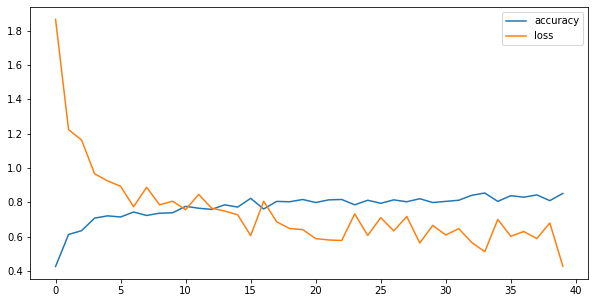

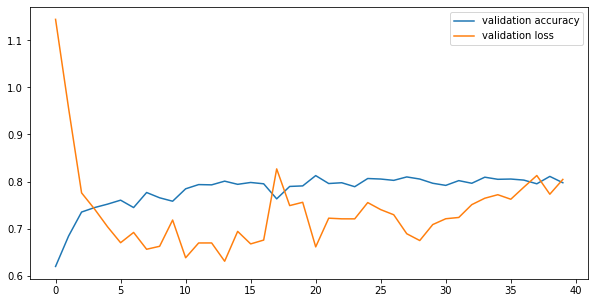

In [28]:
import matplotlib.pyplot as plt

epochs = len(history.history['loss'])
plt.figure(figsize=(10,5))
plt.plot(range(epochs), history.history['accuracy'], label='accuracy')
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(range(epochs), history.history['val_accuracy'], label='validation accuracy')
plt.plot(range(epochs), history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

## Adding a new class - in this case an "unknown" class

Let's crawl Bing for some pics of cats.

In [ ]:
!pip3 install icrawler
from icrawler.builtin import BingImageCrawler

In [24]:
def Fetch_Photos(name, save_dir, num):
  make_dir = save_dir + str(name) + "/" 
  !mkdir make_dir
  google_crawler = BingImageCrawler(storage={'root_dir' : make_dir})
  google_crawler.crawl(keyword=name, max_num=num)

In [ ]:
Fetch_Photos('cat', '/content/bing_cats', 200)

We need to create folder for our new class in the dataset

In [28]:
os.mkdir('/content/Classifier_Model/dataset/Unknown')

And then run the above script to extract cutouts.

In [ ]:
from tensorflow.keras.preprocessing import image as tfimage
import tensorflow as tf
from PIL import Image 
from six import BytesIO
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from six import BytesIO

def load_image_into_numpy_array(path):
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


data_path = '/content/bing_catscat'
folders = os.listdir(data_path)
i=0

file_list = os.listdir(data_path)
for file in file_list:
  if file[-3:]=='jpg':
    path = os.path.join(data_path, file)
    im = Image.open(path)
    rgb_im = im.convert('RGB')

    path = path[:-3] + 'jpg'

    rgb_im.save(path)

    image_np = load_image_into_numpy_array(path)
    
    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = detect_fn(input_tensor)
    detection_scores = detections['detection_scores'][0]
    detection_boxes = detections['detection_boxes'][0]

    width, height = im.size 

    for box, score in zip(detection_boxes, detection_scores):
      left = width*box[1].numpy()
      top = height*box[0].numpy()
      right = width*box[3].numpy()
      bottom = height*box[2].numpy()
      if score < .5:
        break
      
      im1 = im.crop((left, top, right, bottom)) 
      plt.imshow(im1)
      plt.axis('off')
      # Shows the image in image viewer 
      filename = file[:-4]
      plt.savefig('/content/Classifier_Model/dataset/Unknown/cat_' + str(i) + '.jpg', )
      plt.show()
      i+=1

After the process finishes - it's important to see if there aren't examples of already established classes in our new class folder. We need to assign those files to appropriate folders in order to ensure high training accuracy.